In [1]:
import pandas as pd

In [255]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

In [256]:
df.head(25)

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,2,17.0,2,0,0,0,55,True,0,1
5,Ionuț Radu,GK,Bournemouth,2.4,0,0,0,0,0.0,607,...,1,0.0,0,0,0,0,45,True,0,1
6,Andre Brooks,MID,Sheffield Utd,0.5,0,0,3,0,0.0,655,...,0,0.0,1,0,0,0,45,True,0,1
7,Jack Grealish,MID,Man City,4.1,0,0,0,0,0.0,354,...,0,0.0,0,0,0,0,75,False,0,1
8,Emil Krafth,DEF,Newcastle,0.0,0,0,0,0,0.0,417,...,5,0.0,0,0,0,0,45,True,0,1
9,Boubacar Traoré,MID,Wolves,0.5,0,0,0,0,0.0,574,...,1,0.0,0,0,0,0,45,False,0,1


In [259]:
df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [261]:
df.head(5)

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,2,17.0,2,0,0,0,55,True,0,1


In [263]:
gks=df.loc[df['position']=="GK"]
defs=df.loc[df['position']=="DEF"]
mids=df.loc[df['position']=="MID"]
fwds=df.loc[df['position']=="FWD"]

In [265]:
from sklearn.model_selection import train_test_split

In [267]:
y_gks=gks['total_points']
y_defs=defs['total_points']
y_mids=mids['total_points']
y_fwds=fwds['total_points']

x_gks=gks.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_defs=defs.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_mids=mids.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_fwds=fwds.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)

In [211]:
y_gks

5        0
10       0
11       0
14       0
15       0
        ..
29705    0
29708    0
29714    0
29715    3
29722    0
Name: total_points, Length: 3413, dtype: int64

In [213]:
x_gks

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
5,2.4,0,0,0,0,0.0,607,0.0,0.0,0.0,...,1,1,0.0,0,0,0,45,True,0,1
10,-0.5,0,0,0,0,0.0,169,0.0,0.0,0.0,...,3,0,0.0,0,0,0,40,True,0,1
11,1.9,0,0,0,0,0.0,335,0.0,0.0,0.0,...,1,4,0.0,0,0,0,45,False,0,1
14,1.0,0,0,0,0,0.0,491,0.0,0.0,0.0,...,2,2,0.0,0,0,0,40,False,0,1
15,0.5,0,0,0,0,0.0,53,0.0,0.0,0.0,...,1,5,0.0,0,0,0,40,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29705,-1.0,0,0,0,0,0.0,647,0.0,0.0,0.0,...,1,3,0.0,13,125,112,40,False,0,38
29708,0.0,0,0,0,0,0.0,411,0.0,0.0,0.0,...,4,2,0.0,-15,67,82,39,False,0,38
29714,0.0,0,0,0,0,0.0,789,0.0,0.0,0.0,...,4,2,0.0,15,50,35,40,True,0,38
29715,3.8,0,0,18,0,0.0,687,0.0,0.0,0.0,...,1,2,0.0,22145,46910,24765,47,True,0,38


In [269]:
X_train_gks, X_test_gks, y_train_gks, y_test_gks = train_test_split(
  x_gks, y_gks, random_state=104,test_size=0.2, shuffle=False)

In [217]:
from sklearn.linear_model import LinearRegression

In [219]:
reg = LinearRegression().fit(X_train_gks, y_train_gks)

In [221]:
y_lr_train_pred_gks = reg.predict(X_train_gks)
y_lr_test_pred_gks = reg.predict(X_test_gks)

In [223]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_gks = mean_squared_error(y_train_gks, y_lr_train_pred_gks)
lr_train_r2_gks = r2_score(y_train_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_test_gks, y_lr_test_pred_gks)
lr_test_r2_gks = r2_score(y_test_gks, y_lr_test_pred_gks)

In [225]:

print('LR MSE (Train): ', lr_train_mse_gks)
print('LR R2 (Train): ', lr_train_r2_gks)
print('LR MSE (Test): ', lr_test_mse_gks)
print('LR R2 (Test): ', lr_test_r2_gks)

LR MSE (Train):  0.027408177531642833
LR R2 (Train):  0.9919105663615754
LR MSE (Test):  0.029880122844980712
LR R2 (Test):  0.9910271035247


Text(0.5, 0, 'Experimental LogS')

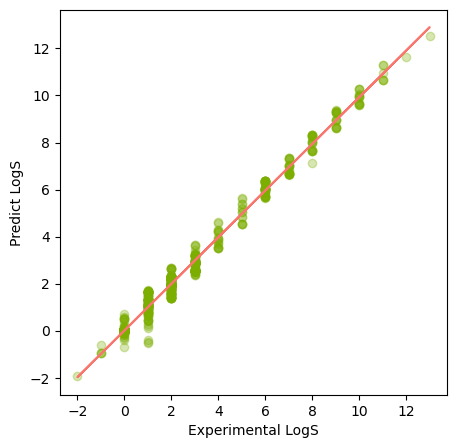

In [227]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_train_gks, y=y_lr_train_pred_gks, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_train_gks, y_lr_train_pred_gks, 1)
p = np.poly1d(z)

plt.plot(y_train_gks, p(y_train_gks), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')

In [229]:
from sklearn.linear_model import SGDRegressor

In [271]:
model = SGDRegressor(max_iter=1000, tol=None)

In [273]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(tol=None)

In [275]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

gks=df.loc[df['position']=="GK"]
defs=df.loc[df['position']=="DEF"]
mids=df.loc[df['position']=="MID"]
fwds=df.loc[df['position']=="FWD"]

y_gks=gks['total_points']
y_defs=defs['total_points']
y_mids=mids['total_points']
y_fwds=fwds['total_points']

x_gks=gks.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_defs=defs.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_mids=mids.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_fwds=fwds.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)

X_train_gks, X_test_gks, y_train_gks, y_test_gks = train_test_split(
  x_gks, y_gks, random_state=104,test_size=0.2, shuffle=False)

In [277]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(tol=None)

In [279]:
y_pred = model.predict(X_test_gks)

In [281]:
mse = mean_squared_error(y_test_gks, y_pred)
r2 = r2_score(y_test_gks, y_pred)



In [283]:
mse

7.095387362108293e+39

In [285]:
r2

-1.8296984892338988e+39